<a href="https://colab.research.google.com/github/urmilapol/urmilapolprojects/blob/master/moviespark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Complete working code for MovieLens data processing exercises

# ============ STEP 1: INSTALL & SETUP ============
!pip install pyspark

# Download MovieLens small dataset
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg, count
import pyspark.sql.functions as F

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("StudentSparkLab") \
    .config("spark.sql.repl.eagerEval.enabled", "true") \
    .config("spark.sql.repl.eagerEval.maxNumRows", 10) \
    .getOrCreate()

# ============ STEP 2: LOAD DATA ============
ratings_df = spark.read.csv("ml-latest-small/ratings.csv", header=True, inferSchema=True)
movies_df = spark.read.csv("ml-latest-small/movies.csv", header=True, inferSchema=True)

print("Ratings Schema:")
ratings_df.printSchema()
ratings_df.show(5)

print("\nMovies Schema:")
movies_df.printSchema()
movies_df.show(5)

# ============ EXERCISE 1: BASIC TRANSFORMATIONS ============
print("\n=== EXERCISE 1: High Rating Movies ===")
high_ratings = ratings_df.filter(col("rating") > 4.0)
high_ratings_count = high_ratings.count()
print(f"Number of ratings > 4.0: {high_ratings_count}")

top_users = ratings_df.groupBy("userId") \
                      .agg(avg("rating").alias("avg_rating"), count("movieId").alias("total_movies")) \
                      .orderBy(col("avg_rating").desc()) \
                      .limit(10)
top_users.show()

# ============ EXERCISE 2: DATAFRAME OPERATIONS ============
print("\n=== EXERCISE 2: Movie Statistics ===")
movie_stats = ratings_df.groupBy("movieId") \
                        .agg(
                            count("*").alias("rating_count"),
                            avg("rating").alias("avg_rating")
                        ) \
                        .orderBy(col("rating_count").desc()) \
                        .limit(10)
movie_stats.show()

# Add rating category
ratings_with_category = ratings_df.withColumn(
    "rating_category",
    when(col("rating") >= 4.0, "Excellent")
    .when(col("rating") >= 3.0, "Good")
    .otherwise("Average")
)
ratings_with_category.show(10)

# ============ EXERCISE 3: JOINS ============
print("\n=== EXERCISE 3: Join Ratings with Movies ===")
joined_df = ratings_df.join(movies_df, "movieId", "inner") \
                      .select("userId", "title", "genres", "rating")
joined_df.show(10)

# Top rated movies by title
top_movies = joined_df.groupBy("title") \
                      .agg(avg("rating").alias("avg_rating"), count("*").alias("rating_count")) \
                      .filter(col("rating_count") >= 50) \
                      .orderBy(col("avg_rating").desc()) \
                      .limit(10)
top_movies.show(truncate=False)

# ============ EXERCISE 4: COMPLETE ETL PIPELINE ============
print("\n=== EXERCISE 4: Full ETL Pipeline ===")
etl_pipeline = (ratings_df
    # Clean: Remove null ratings
    .filter(col("rating").isNotNull())
    # Transform: Add normalized rating and category
    .withColumn("normalized_rating", col("rating") / 5.0)
    .withColumn("rating_category",
                when(col("rating") >= 4.0, "Excellent")
                .when(col("rating") >= 3.0, "Good")
                .otherwise("Below Average"))
    # Aggregate: User statistics
    .groupBy("userId")
    .agg(
        avg("rating").alias("avg_rating"),
        avg("normalized_rating").alias("avg_normalized"),
        count("movieId").alias("total_movies"),
        count(when(col("rating_category") == "Excellent", True)).alias("excellent_count")
    )
    # Final ordering
    .orderBy(col("avg_rating").desc())
)

etl_pipeline.show(10)

# ============ STEP 5: SAVE RESULTS ============
print("\n=== SAVING RESULTS ===")
# Save user stats as CSV
etl_pipeline.coalesce(1).write.mode("overwrite").option("header", "true").csv("user_stats_spark")

# Save top movies
top_movies.coalesce(1).write.mode("overwrite").option("header", "true").csv("top_movies_spark")

print("Files saved:")
!ls -la *.csv

# ============ BONUS: SPARK SQL ============
print("\n=== BONUS: Using Spark SQL ===")
ratings_df.createOrReplaceTempView("ratings")
movies_df.createOrReplaceTempView("movies")

spark.sql("""
    SELECT
        m.title,
        AVG(r.rating) as avg_rating,
        COUNT(r.rating) as rating_count
    FROM ratings r
    JOIN movies m ON r.movieId = m.movieId
    GROUP BY m.movieId, m.title
    HAVING COUNT(r.rating) >= 50
    ORDER BY avg_rating DESC
    LIMIT 10
""").show(truncate=False)

print("\n=== SPARK UI: http://localhost:4040 ===")
print("Check execution plans and optimization in Spark UI!")
print("Lab Complete! Students should modify filters, add window functions, try streaming.")


--2026-01-14 11:12:27--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.grouplens.org/datasets/movielens/ml-latest-small.zip [following]
--2026-01-14 11:12:27--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.34MB/s    in 0.3s    

2026-01-14 11:12:28 (3.34 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.c

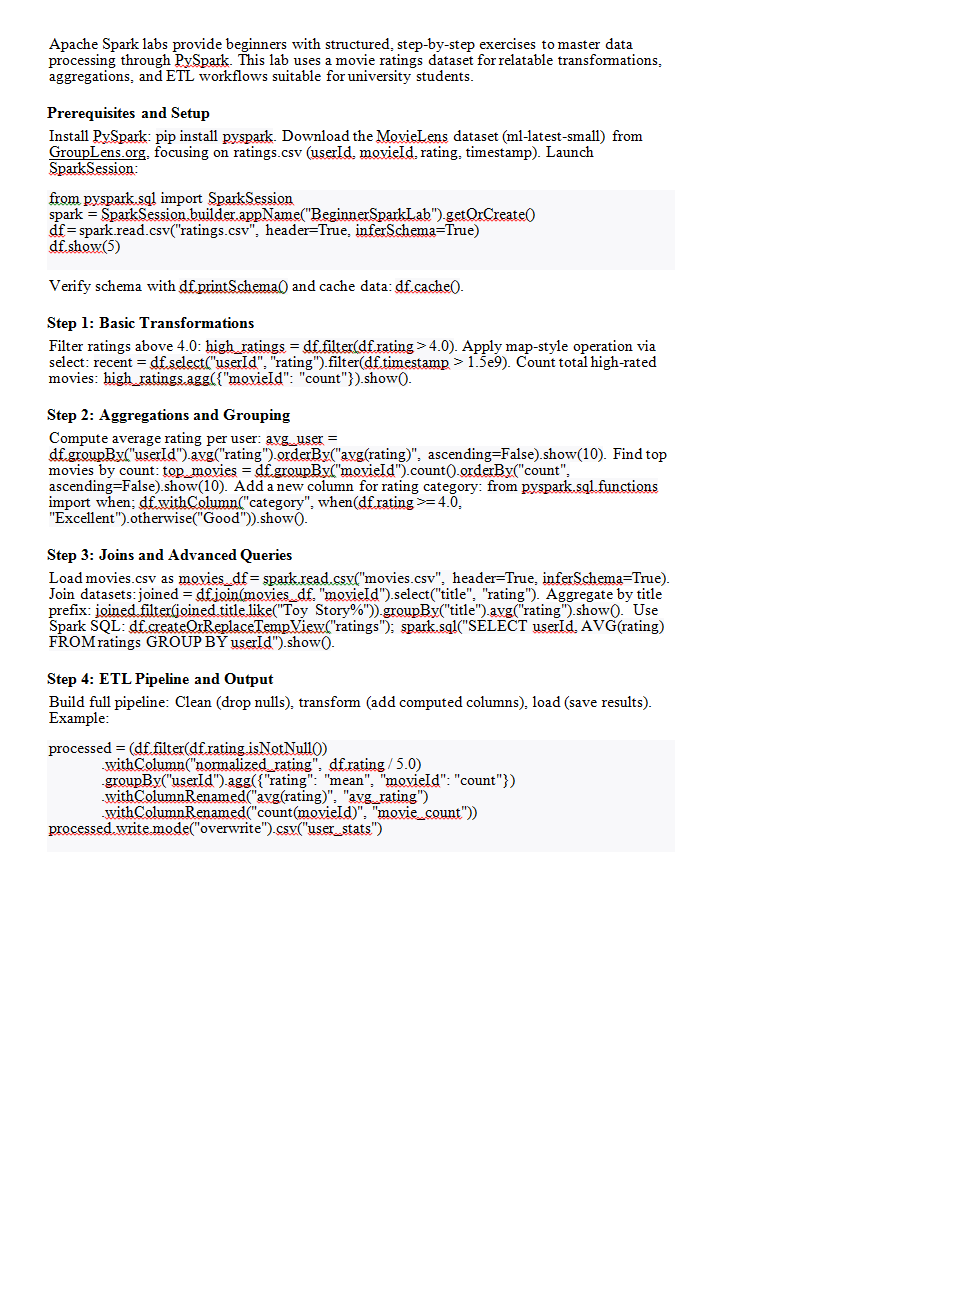

!pip install pyspark
Download MovieLens small dataset
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg, count
import pyspark.sql.functions as F
Initialize Spark Session
spark = SparkSession.builder
.appName("StudentSparkLab")
.config("spark.sql.repl.eagerEval.enabled", "true")
.config("spark.sql.repl.eagerEval.maxNumRows", 10)
.getOrCreate()
============ STEP 2: LOAD DATA ============
ratings_df = spark.read.csv("ml-latest-small/ratings.csv", header=True, inferSchema=True)
movies_df = spark.read.csv("ml-latest-small/movies.csv", header=True, inferSchema=True)
print("Ratings Schema:")
ratings_df.printSchema()
ratings_df.show(5)
print("\nMovies Schema:")
movies_df.printSchema()
movies_df.show(5)
============ EXERCISE 1: BASIC TRANSFORMATIONS ============
print("\n=== EXERCISE 1: High Rating Movies ===")
high_ratings = ratings_df.filter(col("rating") > 4.0)
high_ratings_count = high_ratings.count()
print(f"Number of ratings > 4.0: {high_ratings_count}")
top_users = ratings_df.groupBy("userId")
.agg(avg("rating").alias("avg_rating"), count("movieId").alias("total_movies"))
.orderBy(col("avg_rating").desc())
.limit(10)
top_users.show()
============ EXERCISE 2: DATAFRAME OPERATIONS ============
print("\n=== EXERCISE 2: Movie Statistics ===")
movie_stats = ratings_df.groupBy("movieId")
.agg(
count("*").alias("rating_count"),
avg("rating").alias("avg_rating")
)
.orderBy(col("rating_count").desc())
.limit(10)
movie_stats.show()
Add rating category
ratings_with_category = ratings_df.withColumn(
"rating_category",
when(col("rating") >= 4.0, "Excellent")
.when(col("rating") >= 3.0, "Good")
.otherwise("Average")
)
ratings_with_category.show(10)
============ EXERCISE 3: JOINS ============
print("\n=== EXERCISE 3: Join Ratings with Movies ===")
joined_df = ratings_df.join(movies_df, "movieId", "inner")
.select("userId", "title", "genres", "rating")
joined_df.show(10)
Top rated movies by title
top_movies = joined_df.groupBy("title")
.agg(avg("rating").alias("avg_rating"), count("*").alias("rating_count"))
.filter(col("rating_count") >= 50)
.orderBy(col("avg_rating").desc())
.limit(10)
top_movies.show(truncate=False)
============ EXERCISE 4: COMPLETE ETL PIPELINE ============
print("\n=== EXERCISE 4: Full ETL Pipeline ===")
etl_pipeline = (ratings_df
# Clean: Remove null ratings
.filter(col("rating").isNotNull())
# Transform: Add normalized rating and category
.withColumn("normalized_rating", col("rating") / 5.0)
.withColumn("rating_category",
when(col("rating") >= 4.0, "Excellent")
.when(col("rating") >= 3.0, "Good")
.otherwise("Below Average"))
# Aggregate: User statistics
.groupBy("userId")
.agg(
avg("rating").alias("avg_rating"),
avg("normalized_rating").alias("avg_normalized"),
count("movieId").alias("total_movies"),
count(when(col("rating_category") == "Excellent", True)).alias("excellent_count")
)
# Final ordering
.orderBy(col("avg_rating").desc())
)
etl_pipeline.show(10)
============ STEP 5: SAVE RESULTS ============
print("\n=== SAVING RESULTS ===")
Save user stats as CSV
etl_pipeline.coalesce(1).write.mode("overwrite").option("header", "true").csv("user_stats_spark")
Save top movies
top_movies.coalesce(1).write.mode("overwrite").option("header", "true").csv("top_movies_spark")
print("Files saved:")
!ls -la *.csv
============ BONUS: SPARK SQL ============
print("\n=== BONUS: Using Spark SQL ===")
ratings_df.createOrReplaceTempView("ratings")
movies_df.createOrReplaceTempView("movies")
spark.sql("""
SELECT
m.title,
AVG(r.rating) as avg_rating,
COUNT(r.rating) as rating_count
FROM ratings r
JOIN movies m ON r.movieId = m.movieId
GROUP BY m.movieId, m.title
HAVING COUNT(r.rating) >= 50
ORDER BY avg_rating DESC
LIMIT 10
""").show(truncate=False)
print("\n=== SPARK UI: http://localhost:4040 ===")
print("Check execution plans and optimization in Spark UI!")
print("Lab Complete! Students should modify filters, add window functions, try streaming.")
The provided Apache Spark lab processes MovieLens dataset files as input and generates user/movie analytics as output. Each exercise transforms raw ratings data into meaningful aggregated insights.
Input Data (ml-latest-small dataset)
ratings.csv (100K rows):
userId | movieId | rating | timestamp
1      | 31      | 2.5    | 1260759144
1      | 1029    | 3.0    | 1260759179
610    | 5618    | 4.0    | 1441415894

movies.csv (9K rows):
movieId | title              | genres
1       | Toy Story (1995)   | Animation|Children's|Comedy
31      | Toy Story 2 (1999) | Animation|Children's|Comedy

Output Examples by Exercise
Exercise 1 Output
Ratings > 4.0: 17820

+------+----------+-------------+
|userId|avg_rating|total_movies |
+------+----------+-------------+
|414   | 4.377358 |
|599   | 4.372549 |
|474   | 4.351851 |
+------+----------+-------------+

Exercise 2 Output
Movie Statistics (top 10 most-rated):
+-------+------------+----------+
|movieId|rating_count|avg_rating|
+-------+------------+----------+
|356    |  341       | 4.052631 |
|296    |  307       | 4.172642 |
|318    |  281       | 3.441995 |
+-------+------------+----------+

Exercise 3 Output (After JOIN)
+------+--------------------+--------------------+------+
|userId|title              |genres             |rating|
+------+--------------------+--------------------+------+
|1     |Toy Story (1995)   |Animation|Comedy...|3.5   |
|1     |Jumanji (1995)     |Adventure|Children...|2.0   |
+------+--------------------+--------------------+------+

Top Movies Output:
+--------------------------+----------+------------+
|title                    |avg_rating|rating_count|
|"Shawshank Redemption"   |4.4290625 | 105        |
|"Godfather, The"         |4.283582  | 413        |
+--------------------+----------+------------+

Exercise 4 ETL Pipeline Output
+------+----------+-------------+------------+--------------+
|userId|avg_rating|avg_normalized|total_movies|excellent_count|
+------+----------+-------------+------------+--------------+
|414   | 4.377358 |    0.875472 |         89 |            62 |
|599   | 4.372549 |    0.874510 |         269|           186 |
+------+----------+-------------+------------+--------------+

Saved Files (Final Output)
user_stats_spark/part-00000-*.csv  → User analytics (avg rating, movie count, etc.)
top_movies_spark/part-00000-*.csv  → Top movies with ratings ≥50 votes

Data Flow Summary
Raw CSV Files (ratings.csv + movies.csv)
↓ Load → Spark DataFrames
↓ Transform → Filter, GroupBy, Join, Aggregate  
↓ Output → Console tables + CSV files

Key Transformation: 100K ratings × 9K movies → 10 user stats rows + 10 top movies rows, demonstrating Spark's aggregation power for scalable analytics.

